Импорты и функции

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Метрики
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (np.clip(np.abs(y_true), eps, None)))) * 100

neg_rmse_scorer = make_scorer(lambda y, y_pred: -rmse(y, y_pred))
r2_scorer = make_scorer(r2_score)
neg_mape_scorer = make_scorer(lambda y, y_pred: -mape(y, y_pred))

RANDOM_STATE = 42
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Загрузка и первичный анализ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


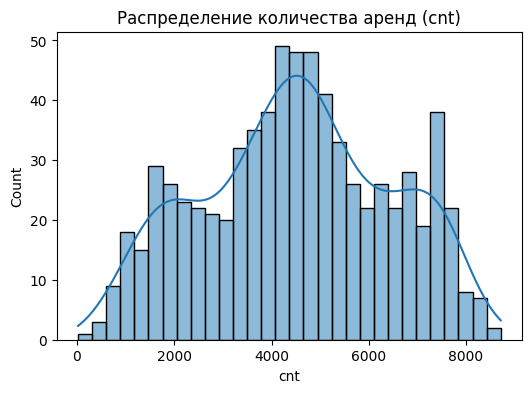

In [4]:
df = pd.read_csv("day.csv")
df.head()

# Основная информация
df.info()
df.describe()
df.isnull().sum()

# Визуализация распределения целевой переменной
plt.figure(figsize=(6,4))
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title("Распределение количества аренд (cnt)")
plt.show()

Предобработка

Убираем ненужные признаки (instant, dteday, casual, registered — чтобы не было утечек).

Масштабируем.

In [5]:
df = df.drop(["instant", "dteday", "casual", "registered"], axis=1)

# Разделяем X и y
X = df.drop("cnt", axis=1)
y = df["cnt"]

Корреляции и VIF

VIF ≈ 1 → признак не коррелирует с другими

VIF < 5 → мультиколлинеарность слабая, признак можно оставлять

VIF 5–10 → есть заметная мультиколлинеарность, стоит проверить

VIF > 10 → сильная мультиколлинеарность, один из признаков нужно убрать

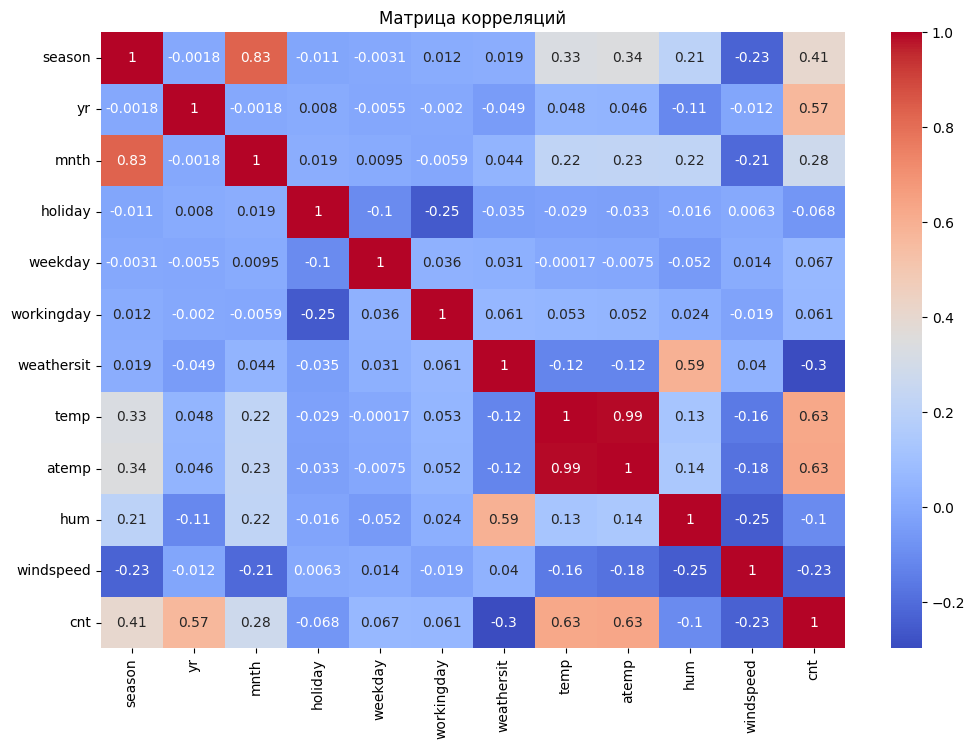

VIF для признаков:
        feature        VIF
0       season   3.548413
1           yr   1.020253
2         mnth   3.333672
3      holiday   1.083126
4      weekday   1.024076
5   workingday   1.076392
6   weathersit   1.748741
7         temp  63.321299
8        atemp  64.343361
9          hum   1.918309
10   windspeed   1.199259


In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Матрица корреляций")
plt.show()

# Масштабируем X для VIF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print("VIF для признаков:\n", vif_data)

Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

Модели с atemp

In [8]:
# линейная регрессия
pipe_lr = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

# гребневая регрессия
pipe_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
param_grid = {"ridge__alpha": [0.1, 1, 10, 50, 100]}
gs_ridge = GridSearchCV(pipe_ridge, param_grid, cv=kf, scoring=neg_rmse_scorer)
gs_ridge.fit(X_train, y_train)
best_ridge = gs_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

print("=== Модели с atemp ===")
print("Линеная: RMSE=%.2f, R²=%.3f, MAPE=%.2f%%" % (rmse(y_test, y_pred_lr), r2_score(y_test, y_pred_lr), mape(y_test, y_pred_lr)))
print("Гребневая (alpha=%s): RMSE=%.2f, R²=%.3f, MAPE=%.2f%%" % (gs_ridge.best_params_["ridge__alpha"], rmse(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge), mape(y_test, y_pred_ridge)))

=== Модели с atemp ===
Линеная: RMSE=831.29, R²=0.828, MAPE=149.38%
Гребневая (alpha=10): RMSE=832.36, R²=0.827, MAPE=148.81%


Модели без atemp

In [10]:
X2 = X.drop("atemp", axis=1)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=RANDOM_STATE)

# линейная регрессия
pipe_lr2 = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipe_lr2.fit(X2_train, y_train)
y_pred_lr2 = pipe_lr2.predict(X2_test)

# гребневая регрессия
pipe_ridge2 = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
param_grid = {"ridge__alpha": [0.1, 1, 10, 50, 100]}
gs_ridge2 = GridSearchCV(pipe_ridge2, param_grid, cv=kf, scoring=neg_rmse_scorer)
gs_ridge2.fit(X2_train, y_train)
best_ridge2 = gs_ridge2.best_estimator_
y_pred_ridge2 = best_ridge2.predict(X2_test)

print("=== Модели без atemp ===")
print("Линейная: RMSE=%.2f, R²=%.3f, MAPE=%.2f%%" % (rmse(y_test, y_pred_lr2), r2_score(y_test, y_pred_lr2), mape(y_test, y_pred_lr2)))
print("Гребневая (alpha=%s): RMSE=%.2f, R²=%.3f, MAPE=%.2f%%" % (gs_ridge2.best_params_["ridge__alpha"], rmse(y_test, y_pred_ridge2), r2_score(y_test, y_pred_ridge2), mape(y_test, y_pred_ridge2)))

=== Модели без atemp ===
Линейная: RMSE=832.78, R²=0.827, MAPE=147.25%
Гребневая (alpha=10): RMSE=834.08, R²=0.827, MAPE=147.01%


Сравнение моделей

In [11]:
results = [
    {"model": "Линейная (с atemp)", "RMSE": rmse(y_test, y_pred_lr), "R²": r2_score(y_test, y_pred_lr), "MAPE": mape(y_test, y_pred_lr)},
    {"model": f"Гребневая (с atemp, alpha={gs_ridge.best_params_['ridge__alpha']})", "RMSE": rmse(y_test, y_pred_ridge), "R²": r2_score(y_test, y_pred_ridge), "MAPE": mape(y_test, y_pred_ridge)},
    {"model": "Линейная (без atemp)", "RMSE": rmse(y_test, y_pred_lr2), "R²": r2_score(y_test, y_pred_lr2), "MAPE": mape(y_test, y_pred_lr2)},
    {"model": f"Гребневая (без atemp, alpha={gs_ridge2.best_params_['ridge__alpha']})", "RMSE": rmse(y_test, y_pred_ridge2), "R²": r2_score(y_test, y_pred_ridge2), "MAPE": mape(y_test, y_pred_ridge2)},
]

res_df = pd.DataFrame(results)
res_df

,model,RMSE,R²,MAPE
0,Линейная (с atemp),831.285155,0.827667,149.381394
1,"Гребневая (с atemp, alpha=10)",832.359023,0.827221,148.813907
2,Линейная (без atemp),832.784518,0.827045,147.251741
3,"Гребневая (без atemp, alpha=10)",834.084513,0.826504,147.012528


PCA для снижения размерности

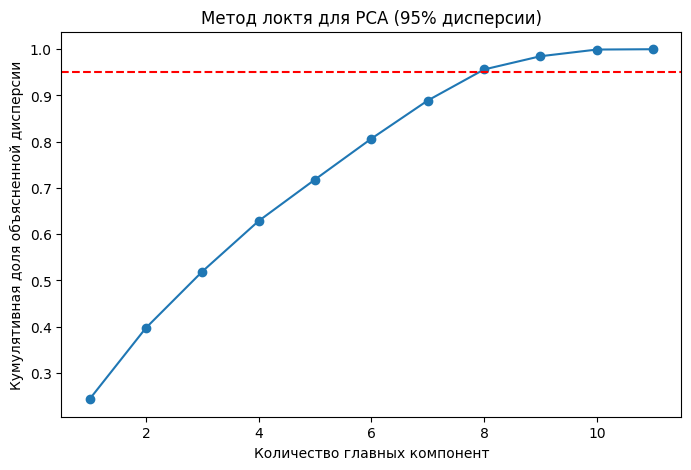

Количество главных компонент для 95% дисперсии: 8


In [12]:
from sklearn.decomposition import PCA

# Стандартизируем данные перед PCA
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X)

# Подбираем количество компонентов, чтобы объяснить ~95% дисперсии
pca = PCA()
X_pca = pca.fit_transform(X_scaled_full)

# График кумулятивной доли объясненной дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.xlabel("Количество главных компонент")
plt.ylabel("Кумулятивная доля объясненной дисперсии")
plt.title("Метод локтя для PCA (95% дисперсии)")
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

# Выбираем количество компонентов, объясняющих 95% дисперсии
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Количество главных компонент для 95% дисперсии: {n_components}")

# Создаем новые признаки по PCA
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled_full)

Train/Test Split для PCA

In [13]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=RANDOM_STATE)

Модели на главных компонентах

In [14]:
# линейная регрессия
pipe_lr_pca = Pipeline([("lr", LinearRegression())])
pipe_lr_pca.fit(X_train_pca, y_train)
y_pred_lr_pca = pipe_lr_pca.predict(X_test_pca)

# гребневая регрессия
pipe_ridge_pca = Pipeline([("ridge", Ridge())])
param_grid = {"ridge__alpha": [0.1, 1, 10, 50, 100]}
gs_ridge_pca = GridSearchCV(pipe_ridge_pca, param_grid, cv=kf, scoring=neg_rmse_scorer)
gs_ridge_pca.fit(X_train_pca, y_train)
best_ridge_pca = gs_ridge_pca.best_estimator_
y_pred_ridge_pca = best_ridge_pca.predict(X_test_pca)

print("=== Модели на PCA-признаках ===")
print("Linear PCA: RMSE=%.2f, R²=%.3f, MAPE=%.2f%%" % (rmse(y_test, y_pred_lr_pca), r2_score(y_test, y_pred_lr_pca), mape(y_test, y_pred_lr_pca)))
print("Ridge PCA (alpha=%s): RMSE=%.2f, R²=%.3f, MAPE=%.2f%%" % (gs_ridge_pca.best_params_["ridge__alpha"], rmse(y_test, y_pred_ridge_pca), r2_score(y_test, y_pred_ridge_pca), mape(y_test, y_pred_ridge_pca)))

=== Модели на PCA-признаках ===
Linear PCA: RMSE=852.42, R²=0.819, MAPE=146.24%
Ridge PCA (alpha=10): RMSE=854.40, R²=0.818, MAPE=146.29%


Сравнение всех моделей

In [16]:
results_pca = [
    {"model": "Линейная PCA", "RMSE": rmse(y_test, y_pred_lr_pca), "R²": r2_score(y_test, y_pred_lr_pca), "MAPE": mape(y_test, y_pred_lr_pca)},
    {"model": f"Гребневая PCA (alpha={gs_ridge_pca.best_params_['ridge__alpha']})", "RMSE": rmse(y_test, y_pred_ridge_pca), "R²": r2_score(y_test, y_pred_ridge_pca), "MAPE": mape(y_test, y_pred_ridge_pca)}
]

# Объединяем с предыдущими результатами
res_df_all = pd.concat([res_df, pd.DataFrame(results_pca)], ignore_index=True)
res_df_all

,model,RMSE,R²,MAPE
0,Линейная (с atemp),831.285155,0.827667,149.381394
1,"Гребневая (с atemp, alpha=10)",832.359023,0.827221,148.813907
2,Линейная (без atemp),832.784518,0.827045,147.251741
3,"Гребневая (без atemp, alpha=10)",834.084513,0.826504,147.012528
4,Линейная PCA,852.415049,0.818795,146.241422
5,Гребневая PCA (alpha=10),854.401745,0.817949,146.290880
